# The goal here is to use predicted probabilities, plot precision/recall vs threshold, and pick a threshold for business needs.

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


## Imports + load + preprocessing + train

In [3]:
from src.data_loader import load_telco_csv
from src.preprocessing import make_xy, clean_telco, one_hot_encode
from src.split import stratified_split
from src.models import make_logistic_regression
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt


df = load_telco_csv("../../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X, y = make_xy(df)
X, y = clean_telco(X, y)
X = one_hot_encode(X)

X_train, X_test, y_train, y_test = stratified_split(X, y)

model = make_logistic_regression()
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]


/Users/arissalimi/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Compute precision/recall vs threshold

In [20]:

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

print("precision length:", len(precision))
print("recall length:", len(recall))
print("thresholds length:", len(thresholds))


precision length: 1756
recall length: 1756
thresholds length: 1755


# Define the interval you care about (precision + recall)

In [21]:
MIN_RECALL = 0.70
MIN_PRECISION = 0.40

# Build arrays aligned with thresholds
prec_t = precision[:-1]
rec_t = recall[:-1]

valid_idx = np.where((rec_t >= MIN_RECALL) & (prec_t >= MIN_PRECISION))[0]

print("Number of valid thresholds:", len(valid_idx))


Number of valid thresholds: 533


# Choose threshold inside the valid region
## choose first valid threshold (simple, same as your CLI)

In [22]:
chosen_threshold = thresholds[valid_idx[0]]
chosen_threshold


np.float64(0.25507441900793965)

# Plot with constraint lines + chosen threshold

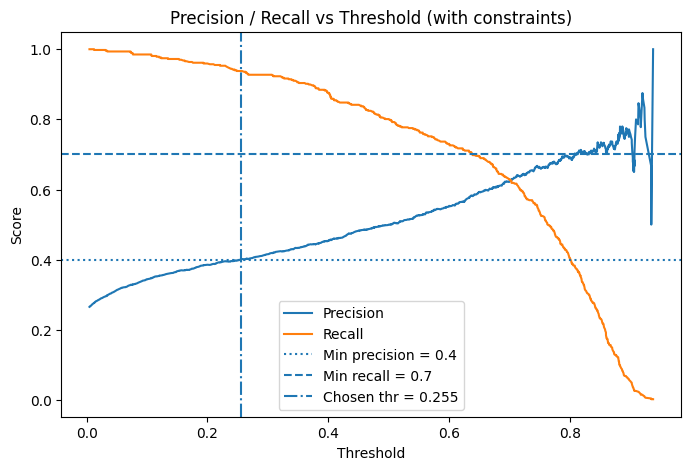

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, prec_t, label="Precision")
plt.plot(thresholds, rec_t, label="Recall")

plt.axhline(MIN_PRECISION, linestyle=":", label=f"Min precision = {MIN_PRECISION}")
plt.axhline(MIN_RECALL, linestyle="--", label=f"Min recall = {MIN_RECALL}")

plt.axvline(chosen_threshold, linestyle="-.", label=f"Chosen thr = {chosen_threshold:.3f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall vs Threshold (with constraints)")
plt.legend()
plt.show()


# Let's Zoom the plot

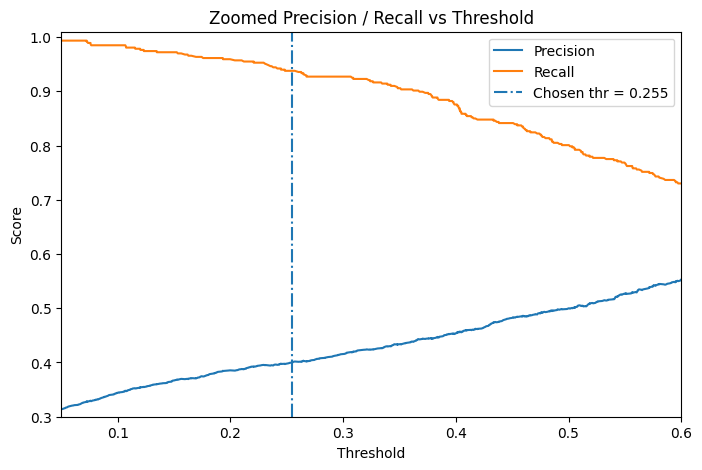

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, prec_t, label="Precision")
plt.plot(thresholds, rec_t, label="Recall")
plt.axvline(chosen_threshold, linestyle="-.", label=f"Chosen thr = {chosen_threshold:.3f}")

plt.xlim(0.05, 0.60)     # adjust if needed
plt.ylim(0.30, 1.01)     # focus on meaningful region

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Zoomed Precision / Recall vs Threshold")
plt.legend()
plt.show()


# Now, let's Apply threshold + evaluate

In [25]:
y_custom = (y_proba >= chosen_threshold).astype(int)
print("Chosen threshold:", chosen_threshold)
print(classification_report(y_test, y_custom, digits=4))


Chosen threshold: 0.25507441900793965
              precision    recall  f1-score   support

           0     0.9563    0.4911    0.6489      1291
           1     0.4000    0.9379    0.5608       467

    accuracy                         0.6098      1758
   macro avg     0.6781    0.7145    0.6049      1758
weighted avg     0.8085    0.6098    0.6255      1758

